<a href="https://colab.research.google.com/github/andreamurillomtz/TinyML_Weather_Station/blob/main/Weather_Station.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Dataset

In [ ]:
!pip install wwo-hist

from wwo_hist import retrieve_hist_data

# Hour frequency
frequency = 1
api_key = '9cc44cbe871e464eb4f32722242602'
location_list = ['canazei']
hist_df = retrieve_hist_data(api_key,
                             location_list,
                             '01-JAN-2011',
                             '31-DEC-2020',
                             frequency,
                             location_label = False,
                             export_csv = False,
                             store_df = True)





Retrieving weather data for canazei


Currently retrieving data for canazei: from 2011-01-01 to 2011-01-31


/usr/local/lib/python3.10/dist-packages/wwo_hist/__init__.py:69: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  list_mon_begin = pd.date_range(start_date, end_date, freq='MS', closed='right')
/usr/local/lib/python3.10/dist-packages/wwo_hist/__init__.py:74: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  list_mon_end = pd.date_range(start_date, end_date, freq='M', closed='left')


Time elapsed (hh:mm:ss.ms) 0:00:01.903967
Currently retrieving data for canazei: from 2011-02-01 to 2011-02-28
Time elapsed (hh:mm:ss.ms) 0:00:03.987528
Currently retrieving data for canazei: from 2011-03-01 to 2011-03-31
Time elapsed (hh:mm:ss.ms) 0:00:06.194824
Currently retrieving data for canazei: from 2011-04-01 to 2011-04-30
Time elapsed (hh:mm:ss.ms) 0:00:08.022747
Currently retrieving data for canazei: from 2011-05-01 to 2011-05-31
Time elapsed (hh:mm:ss.ms) 0:00:10.071864
Currently retrieving data for canazei: from 2011-06-01 to 2011-06-30
Time elapsed (hh:mm:ss.ms) 0:00:13.044711
Currently retrieving data for canazei: from 2011-07-01 to 2011-07-31
Time elapsed (hh:mm:ss.ms) 0:00:14.505551
Currently retrieving data for canazei: from 2011-08-01 to 2011-08-31
Time elapsed (hh:mm:ss.ms) 0:00:16.035623
Currently retrieving data for canazei: from 2011-09-01 to 2011-09-30
Time elapsed (hh:mm:ss.ms) 0:00:17.402968
Currently retrieving data for canazei: from 2011-10-01 to 2011-10-31
T

Separate data into temperature (C°), humidity and snowlevels (cm)

In [ ]:
t_list = hist_df[0].tempC.astype(float).to_list() # Stores temperatue data
h_list = hist_df[0].humidity.astype(float).to_list() # Stores humidity data
s_list = hist_df[0].totalSnow_cm.astype(float).to_list() # Stores snow level data

Labeling the set

In [ ]:
def gen_label(snow):
  if snow > 5:
    return "Yes" # Output label
  else:
    return "No" # Output label for it's not gonna snow

# Main
labels_list = []
for snow, temp in zip(s_list, t_list):
  labels_list.append(gen_label(snow))

Building the dataset

In [ ]:
import pandas as pd
csv_header = ["Temp0", "Temp1", "Temp2",
              "Humi0", "Humi1", "Humi2", "Snow"]
# Use pandas to format the dataset in their respective column
dataset_df = pd.DataFrame(list(zip(
t_list[:-2], t_list[1:-1], t_list[2:],
h_list[:-2], h_list[1:-1], h_list[2:],
labels_list[2:])), columns = csv_header)

Balancing dataset by undersampling majority class

In this dataset the 'No' class has 98.6% of all instances

In [ ]:
df0 = dataset_df[dataset_df['Snow'] == "No"]
df1 = dataset_df[dataset_df['Snow'] == "Yes"]
if len(df1.index) < len(df0.index):
  df0_sub = df0.sample(len(df1.index))
  dataset_df = pd.concat([df0_sub, df1])
else:
  df1_sub = df1.sample(len(df0.index))
  dataset_df = pd.concat([df1_sub, df0])

Z-score scaling so that model is not influenced more by larger values ( new_value = (old_value - mean_value_of_input_features)/standard_deviation_of_input_features )

In [ ]:
import numpy as np
from numpy import mean
from numpy import std

t_list = dataset_df['Temp0'].tolist() # Get all temperature values
h_list = dataset_df['Humi0'].tolist() # Get humidity values
t_list = t_list + dataset_df['Temp2'].tail(2).tolist()
h_list = h_list + dataset_df['Humi2'].tail(2).tolist()

# Calculate mean and standard deviation for Z-scaling
t_avg = mean(t_list)
h_avg = mean(h_list)
t_std = std(t_list)
h_std = std(h_list)
print("Results:")
print("Temperature - [MEAN, STD]  ", round(t_avg, 5), round(t_std, 5))
print("Humidity - [MEAN, STD]     ", round(h_avg, 5), round(h_std, 5))

# For reference:
# Temperature - [MEAN, STD]   2.36966 6.78369
# Humidity - [MEAN, STD]      86.54579 13.74604

#Scale features wiht the Z-score
def scaling(val, avg, std):
  return (val - avg) / (std)

dataset_df['Temp0'] = dataset_df['Temp0'].apply(lambda x: scaling(x, t_avg, t_std))
dataset_df['Temp1'] = dataset_df['Temp1'].apply(lambda x: scaling(x, t_avg, t_std))
dataset_df['Temp2'] = dataset_df['Temp2'].apply(lambda x: scaling(x, t_avg, t_std))
dataset_df['Humi0'] = dataset_df['Humi0'].apply(lambda x: scaling(x, h_avg, h_std))
dataset_df['Humi1'] = dataset_df['Humi1'].apply(lambda x: scaling(x, h_avg, h_std))
dataset_df['Humi2'] = dataset_df['Humi2'].apply(lambda x: scaling(x, h_avg, h_std))


Results:
Temperature - [MEAN, STD]   2.39117 6.75854
Humidity - [MEAN, STD]      86.45186 13.81471


Normalization of input features

<Axes: title={'center': 'Scaled humidity'}, ylabel='Count'>

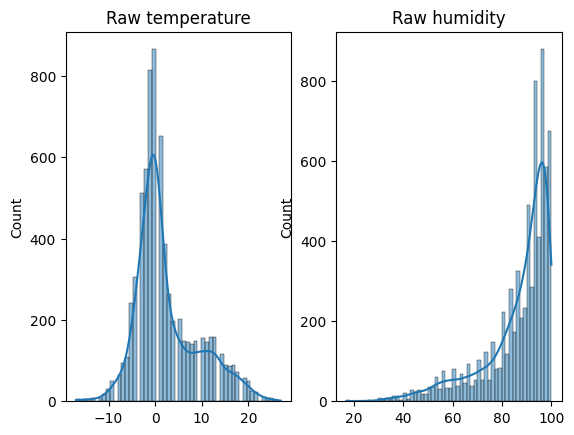

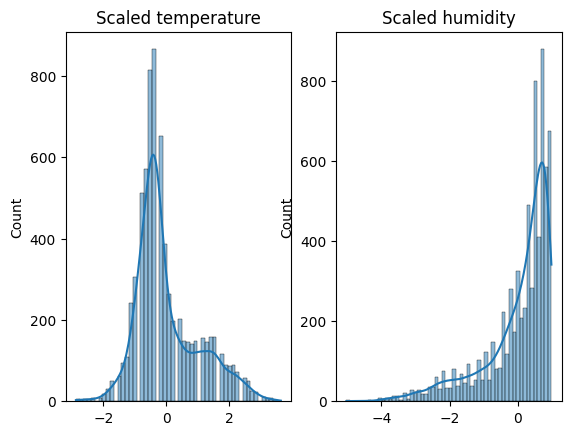

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

t_norm_list = dataset_df['Temp0'].tolist()
h_norm_list = dataset_df['Humi0'].tolist()
fig, ax = plt.subplots( 1,2 )
ax[0].set_title( "Raw temperature" )
ax[1].set_title( "Raw humidity" )
sns.histplot( t_list, ax=ax[0], kde=True )
sns.histplot( h_list, ax=ax[1], kde=True )
fig, ax=plt.subplots(1,2)
sns.histplot( t_norm_list, ax=ax[0], kde=True )
ax[0].set_title( "Scaled temperature" )
ax[1].set_title( "Scaled humidity" )
sns.histplot( h_norm_list, ax=ax[1], kde=True )

# Train Model

Extract input features (x) and output labels (y) from dataset (dataset_df)

In [ ]:
f_names = dataset_df.columns.values[0:6] # Features
l_name  = dataset_df.columns.values[6:7] # Labels
x = dataset_df[f_names] # Features
y = dataset_df[l_name]# Labels

# Encode labels in numerical values
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
labelencoder.fit(y.Snow)
y_encoded = labelencoder.transform(y.Snow)

Split data into train(80%), validation(10%), test(10%) datasets

In [ ]:
from sklearn.model_selection import train_test_split
# Split 1 (80% vs 20%)
x_train, x_validate_test, y_train, y_validate_test = train_test_split(x, y_encoded, test_size=0.20, random_state = 1)
# Split 2 (50% vs 50%)
x_test, x_validate, y_test, y_validate = train_test_split(x_validate_test, y_validate_test, test_size=0.50, random_state = 3)


Create Model (Keras API)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential()
model.add(layers.Dense(12, activation='relu',
          input_shape=(len(f_names),)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                84        
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 97 (388.00 Byte)
Trainable params: 97 (388.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model compilation

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Train model

In [ ]:
NUM_EPOCHS=12
BATCH_SIZE=64
history = model.fit(x_train, y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_validate,
                                     y_validate))

Epoch 1/12
91/91 [==============================] - 2s 8ms/step - loss: 0.5405 - accuracy: 0.7592 - val_loss: 0.4636 - val_accuracy: 0.8441
Epoch 2/12
91/91 [==============================] - 0s 4ms/step - loss: 0.4538 - accuracy: 0.8182 - val_loss: 0.4042 - val_accuracy: 0.8428
Epoch 3/12
91/91 [==============================] - 1s 6ms/step - loss: 0.4157 - accuracy: 0.8258 - val_loss: 0.3733 - val_accuracy: 0.8386
Epoch 4/12
91/91 [==============================] - 1s 8ms/step - loss: 0.3952 - accuracy: 0.8268 - val_loss: 0.3565 - val_accuracy: 0.8428
Epoch 5/12
91/91 [==============================] - 0s 3ms/step - loss: 0.3838 - accuracy: 0.8296 - val_loss: 0.3471 - val_accuracy: 0.8414
Epoch 6/12
91/91 [==============================] - 0s 3ms/step - loss: 0.3775 - accuracy: 0.8336 - val_loss: 0.3415 - val_accuracy: 0.8386
Epoch 7/12
91/91 [==============================] - 0s 2ms/step - loss: 0.3716 - accuracy: 0.8382 - val_loss: 0.3379 - val_accuracy: 0.8414
Epoch 8/12
91/91 [==

Cross Validation

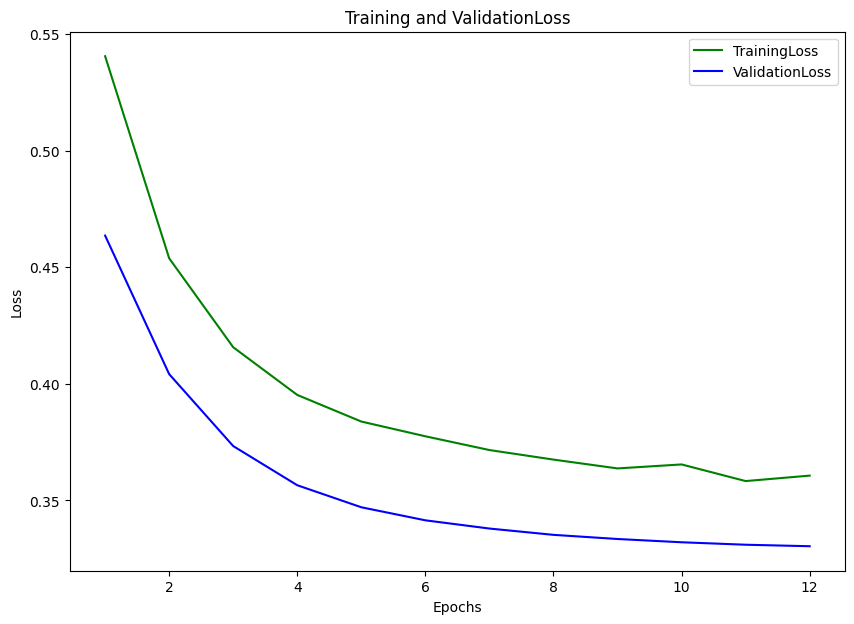

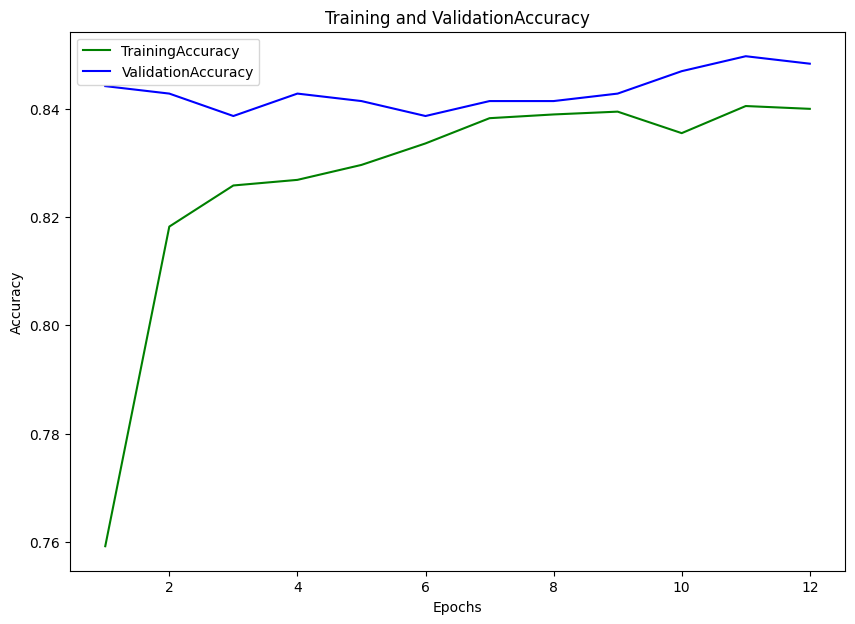

In [ ]:
loss_train = history.history['loss']
loss_val   = history.history['val_loss']
acc_train  = history.history['accuracy']
acc_val    = history.history['val_accuracy']
epochs     = range(1, NUM_EPOCHS + 1)
def plot_train_val_history( x, y_train, y_val, type_txt ):
  plt.figure(figsize = ( 10,7 ))
  plt.plot( x, y_train, 'g', label='Training'+type_txt )
  plt.plot( x, y_val, 'b', label='Validation'+type_txt )
  plt.title( 'Training and Validation'+type_txt )
  plt.xlabel( 'Epochs' )
  plt.ylabel( type_txt )
  plt.legend()
  plt.show()
plot_train_val_history( epochs,
                       loss_train, loss_val,
                       "Loss" )
plot_train_val_history( epochs,
                       acc_train, acc_val,
                       "Accuracy" )

In [ ]:
model.save("snow_forecast")

## Confusion Matrix performance evaluation

NxN (number of output classes) matrix with number of correct and incorrect predictions on test dataset.

In this case it's 2x2 becasue it's a binary classification (True Positive/False Positive/False Negative/True Negative)

**Accuracy** = (TP + TN) / (TP + TN + FN + FP)

**Recall** = TP / (TP + FN) // Should be high (only for positive samples)

**Precision** = TP / (TP + FP) // Should be high

<ins>Evaluate both recall and precision simultaneous</ins>

**F-score** = (2 * recall * precision) / (recall + precision) // The higher

In [ ]:
y_test_pred = model.predict(x_test)
y_test_pred = (y_test_pred > 0.5).astype("int32")

23/23 [==============================] - 0s 1ms/step


In [ ]:
# Computing confusion matrix
import sklearn
cm = sklearn.metrics.confusion_matrix(y_test,
                                      y_test_pred)

<Axes: >

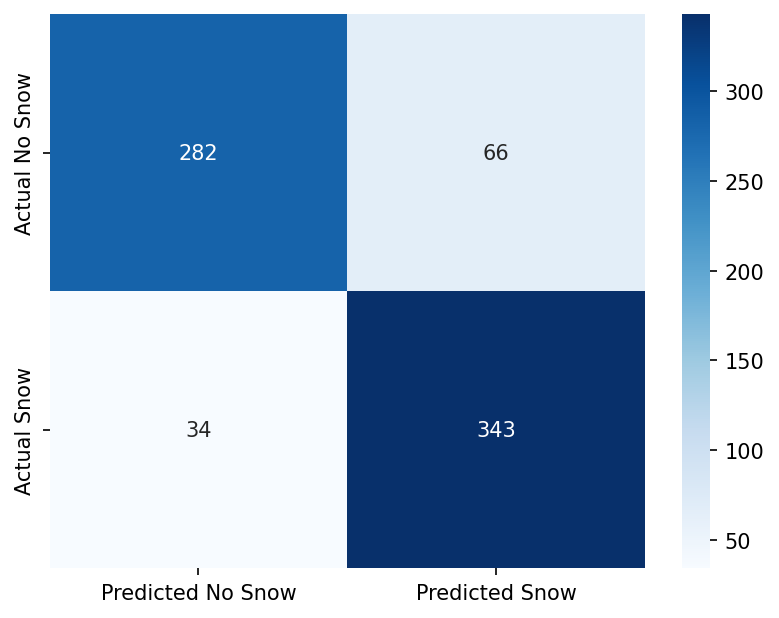

In [ ]:
# Display confusion matrix
index_names  = ["Actual No Snow", "Actual Snow"]
column_names = ["Predicted No Snow", "Predicted Snow"]
df_cm = pd.DataFrame(cm, index = index_names,
                     columns = column_names)
plt.figure(dpi=150)
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")

In [ ]:
# Calculating the recall, precision, F-score metrics
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]
accur  = (TP + TN) / (TP + TN + FN + FP)
precis = TP / (TP + FP)
recall = TP / (TP + FN)
f_score = (2 * recall * precis) / (recall + precis)
print("Accuracy:  ", round(accur, 3))
print("Recall:    ", round(recall, 3))
print("Precision: ", round(precis, 3))
print("F-score:   ", round(f_score, 3))


Accuracy:   0.862
Recall:     0.91
Precision:  0.839
F-score:    0.873


# Quantizing Model
Int 8-bit quantization with TensorFlow Lite (.tflite)

Model weights: symmetric quantization
I/O each layer: asymmetric quantization

**Per-tensor**: Quantization parameters are same for all tensor elements (usually)  
**Per-channel**: Quantization parameters are different for each feature map of the tensors

### Generating a Representative Dataset
Reduce risk of an accuracy drop

In [ ]:
# Calibrate quantization with some random ramples
def representative_data_gen():
  data = tf.data.Dataset.from_tensor_slices(x_test)
  for i_value in data.batch(1).take(100):
    i_value_f32 = tf.dtypes.cast(i_value, tf.float32)
    yield [i_value_f32]

## TensorFlow Lite Converter

In [ ]:
TF_MODEL = "snow_forecast"
converter = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)

## Initialize arguments for 8-bit quantization

# Representative dataset
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
# Optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT] # Optimizes size and latency
# Supported ops
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Inference input/output type
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

## Conversion
tflite_model_quant = converter.convert()


## Save TFLite model (.tflite)


In [ ]:
TFL_MODEL_FILE = "snow_model.tflite"
open(TFL_MODEL_FILE, "wb").write(tflite_model_quant)

2088

# Convert model to a constant C-byte array
Because there's no OS in MCU

In [ ]:
!apt-get update && apt-get -qq install xxd
!xxd -i "snow_model.tflite" > model.h
!sed -i 's/unsigned char/const unsigned char/g' model.h
!sed -i 's/const/alignas(8) const/g' model.h

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [44.6 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,874 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,505 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.co

In [ ]:
size_tfl_model = len(tflite_model_quant)
print(len(tflite_model_quant), "bytes")


2088 bytes
